## Song Classification with Random Forest

#### Import packages

In [1]:
# Numerical computing packages
import numpy as np
import pandas as pd

# Machine learning packages
import sklearn
from sklearn import preprocessing, svm, datasets
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score 
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer


# Statistics packages
from scipy.stats import boxcox

# Plotting packages
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

#Random packages
import random
from itertools import cycle

# Matplotlib backend for notebook
%matplotlib inline 

In [2]:
# Initialize random seed
seed = random.seed(13683355)

### Data processing

In [3]:
# Load dataframe
df = pd.read_csv('musicData.csv')
df.head()

instance_id           artist_name            track_name  popularity  \
0      32894.0              Röyksopp  Röyksopp's Night Out        27.0   
1      46652.0  Thievery Corporation      The Shining Path        31.0   
2      30097.0        Dillon Francis             Hurricane        28.0   
3      62177.0              Dubloadz                 Nitro        34.0   
4      24907.0           What So Not      Divide & Conquer        32.0   

   acousticness  danceability  duration_ms  energy  instrumentalness key  \
0       0.00468         0.652         -1.0   0.941           0.79200  A#   
1       0.01270         0.622     218293.0   0.890           0.95000   D   
2       0.00306         0.620     215613.0   0.755           0.01180  G#   
3       0.02540         0.774     166875.0   0.700           0.00253  C#   
4       0.00465         0.638     222369.0   0.587           0.90900  F#   

   liveness  loudness   mode  speechiness               tempo obtained_date  \
0     0.115    -5.201  Minor       0.0748             100.889         4-Apr   
1     0.124    -7.043  Minor       0.0300  115.00200000000001         4-Apr   
2     0.534    -4.617  Major       0.0345             127.994         4-Apr   
3     0.157    -4.498  Major       0.2390             128.014         4-Apr   
4     0.157    -6.266  Major       0.0413             145.036         4-Apr   

   valence music_genre  
0    0.759  Electronic  
1    0.531  Electronic  
2    0.333  Electronic  
3    0.270  Electronic  
4    0.323  Electronic

#### Remove null entries

In [4]:
# Check for null data
df.isnull().sum()

instance_id         5
artist_name         5
track_name          5
popularity          5
acousticness        5
danceability        5
duration_ms         5
energy              5
instrumentalness    5
key                 5
liveness            5
loudness            5
mode                5
speechiness         5
tempo               5
obtained_date       5
valence             5
music_genre         5
dtype: int64

In [5]:
# Identify null entries
instance_id_null = df[df['instance_id'].isnull()].index.tolist()
instance_id_null

[10000, 10001, 10002, 10003, 10004]

In [6]:
# Remove null entries
df = df.drop(labels=[10000, 10001, 10002, 10003, 10004], axis=0)

# Reset index
df = df.reset_index()

#### Remove unnecessary columns

In [7]:
# Drop the unnecessary columns
df = df.drop(columns=['index','instance_id','artist_name','track_name', 'obtained_date'])

#### Encode categorical variables

In [8]:
# There were 12 different values for key
keys = sorted(df['key'].unique())

# Add 12 columns
for i in range(0,12):
    indices = df[df['key'] == keys[i]].index.tolist()
    encoded = np.zeros(50000)
    encoded[indices] = 1
    # Add encoded values
    df.insert(loc = 7+i, column = keys[i], value = encoded)

In [9]:
# Drop original key column
df = df.drop(columns= 'key')

In [10]:
# There were 2 different values for mode
modes = sorted(df['mode'].unique())

# Add 12 columns
for i in range(0,2):
    indices = df[df['mode'] == modes[i]].index.tolist()
    encoded = np.zeros(50000)
    encoded[indices] = 1
    # Add encoded values
    df.insert(loc = 22+i, column = modes[i], value = encoded)

In [11]:
# Drop original mode column
df = df.drop(columns= 'mode')

In [12]:
# Remove overdetermined columns
df = df.drop(columns= ['G#', 'Minor'])

#### Check for missing values

In [13]:
# Count number of entries with this value
col_vals = df['popularity'].unique()
col_vals = sorted(col_vals)

# Print first and last five
print(col_vals[0:5],"...",col_vals[-5:])

[0.0, 1.0, 2.0, 3.0, 4.0] ... [94.0, 95.0, 96.0, 97.0, 99.0]


In [14]:
# Count number of entries with this value
col_vals = df['acousticness'].unique()
col_vals = sorted(col_vals)

# Print first and last five
print(col_vals[0:5],"...",col_vals[-5:])

[0.0, 1.02e-06, 1.27e-06, 1.37e-06, 1.38e-06] ... [0.992, 0.993, 0.9940000000000001, 0.995, 0.996]


In [15]:
# Count number of entries with this value
col_vals = df['danceability'].unique()
col_vals = sorted(col_vals)

# Print first and last five
print(col_vals[0:5],"...",col_vals[-5:])

[0.0596, 0.06, 0.0602, 0.0606, 0.0607] ... [0.977, 0.978, 0.9790000000000001, 0.98, 0.986]


In [16]:
# Count number of entries with this value
col_vals = df['duration_ms'].unique()
col_vals = sorted(col_vals)

# Print first and last five
print(col_vals[0:5],"...",col_vals[-5:])

[-1.0, 15509.0, 16316.0, 19693.0, 20096.0] ... [2764934.0, 3195440.0, 4276000.0, 4497994.0, 4830606.0]


In [17]:
# Count number of entries with this value
col_vals = df['energy'].unique()
col_vals = sorted(col_vals)

# Print first and last five
print(col_vals[0:5],"...",col_vals[-5:])

[0.000792, 0.000795, 0.000825, 0.0009, 0.0009429999999999] ... [0.995, 0.996, 0.997, 0.998, 0.9990000000000001]


In [18]:
# Count number of entries with this value
col_vals = df['instrumentalness'].unique()
col_vals = sorted(col_vals)

# Print first and last five
print(col_vals[0:5],"...",col_vals[-5:])

[0.0, 1e-06, 1.01e-06, 1.02e-06, 1.03e-06] ... [0.9890000000000001, 0.992, 0.993, 0.9940000000000001, 0.996]


In [19]:
# Count number of entries with this value
col_vals = df['liveness'].unique()
col_vals = sorted(col_vals)

# Print first and last five
print(col_vals[0:5],"...",col_vals[-5:])

[0.00967, 0.0136, 0.0157, 0.0169, 0.0173] ... [0.991, 0.992, 0.993, 0.996, 1.0]


In [20]:
# Count number of entries with this value
col_vals = df['loudness'].unique()
col_vals = sorted(col_vals)

# Print first and last five
print(col_vals[0:5],"...",col_vals[-5:])

[-47.04600000000001, -46.985, -46.507, -46.122, -46.052] ... [1.585, 1.61, 1.893, 1.949, 3.7439999999999998]


In [21]:
# Count number of entries with this value
col_vals = df['speechiness'].unique()
col_vals = sorted(col_vals)

# Print first and last five
print(col_vals[0:5],"...",col_vals[-5:])

[0.0223, 0.0224, 0.0225, 0.0226, 0.0227] ... [0.927, 0.932, 0.9390000000000001, 0.941, 0.9420000000000001]


In [22]:
# Count number of entries with this value
col_vals = df['tempo'].unique()
col_vals = sorted(col_vals)

# Print first and last five
print(col_vals[0:5],"...",col_vals[-5:])

['100.0', '100.001', '100.00200000000001', '100.00299999999999', '100.00399999999999'] ... ['99.99600000000001', '99.99700000000001', '99.99799999999999', '99.999', '?']


In [23]:
# Count number of entries with this value
col_vals = df['valence'].unique()
col_vals = sorted(col_vals)

# Print first and last five
print(col_vals[0:5],"...",col_vals[-5:])

[0.0, 0.0193, 0.0205, 0.0234, 0.0241] ... [0.986, 0.987, 0.9890000000000001, 0.99, 0.992]


In [24]:
# Count number of entries with this value
col_vals = df['music_genre'].unique()
col_vals = sorted(col_vals)

# Print all values
print(col_vals)

['Alternative', 'Anime', 'Blues', 'Classical', 'Country', 'Electronic', 'Hip-Hop', 'Jazz', 'Rap', 'Rock']


#### Set missing values to NaN

In [25]:
# See all unique values in tempo
col_vals = df['tempo'].unique()

# Crop all unique values
new_col_vals = []
for i in col_vals:
    if len(i) > 3:
        new_col_vals.append(i[0:3])
    else:
        new_col_vals.append(i)
        
new_col_vals = set(new_col_vals)

In [26]:
print(new_col_vals)

{'210', '168', '140', '172', '64.', '102', '201', '213', '127', '184', '105', '159', '193', '111', '118', '181', '76.', '97.', '91.', '48.', '95.', '149', '175', '152', '74.', '112', '79.', '155', '161', '199', '138', '122', '205', '146', '186', '99.', '157', '136', '35.', '206', '142', '197', '202', '166', '219', '215', '101', '68.', '71.', '56.', '103', '61.', '87.', '198', '75.', '176', '194', '84.', '134', '173', '59.', '212', '107', '60.', '55.', '143', '217', '65.', '216', '88.', '62.', '86.', '191', '165', '167', '200', '131', '67.', '70.', '154', '187', '98.', '124', '220', '164', '123', '171', '133', '183', '50.', '141', '160', '54.', '85.', '94.', '218', '203', '182', '188', '37.', '125', '135', '132', '211', '169', '80.', '192', '51.', '49.', '121', '162', '96.', '185', '129', '147', '69.', '52.', '137', '109', '100', '47.', '130', '150', '46.', '63.', '144', '170', '115', '73.', '106', '196', '153', '53.', '208', '40.', '163', '178', '82.', '119', '117', '78.', '190', '207'

In [27]:
# Null tempo values = NaN
for i in df.index:
    if df.at[i, "tempo"] == '?':
        df.at[i, "tempo"] = float('NaN')

In [28]:
# Null duration_ms values = NaN
for i in df.index:
    if df.at[i, "duration_ms"] == -1.0:
        df.at[i, "duration_ms"] = float('NaN')

In [29]:
# Check for null values
df.isnull().sum()

popularity             0
acousticness           0
danceability           0
duration_ms         4939
energy                 0
instrumentalness       0
A                      0
A#                     0
B                      0
C                      0
C#                     0
D                      0
D#                     0
E                      0
F                      0
F#                     0
G                      0
liveness               0
loudness               0
speechiness            0
Major                  0
tempo               4980
valence                0
music_genre            0
dtype: int64

#### Impute missing values

In [30]:
# Temporarily hold out target
df_hold = pd.DataFrame()
df_hold.insert(loc=0, column='music_genre', value = df['music_genre'])
df = df.drop(columns = 'music_genre')

In [31]:
# Use KNN Imputation
imputer = KNNImputer()
imputer.fit(df)
dftrans = imputer.transform(df)
df = pd.DataFrame(dftrans, columns = df.columns) 

In [32]:
# Check for null values
df.isnull().sum()

popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
A                   0
A#                  0
B                   0
C                   0
C#                  0
D                   0
D#                  0
E                   0
F                   0
F#                  0
G                   0
liveness            0
loudness            0
speechiness         0
Major               0
tempo               0
valence             0
dtype: int64

#### Distribution of features

Text(0, 0.5, 'Frequency')

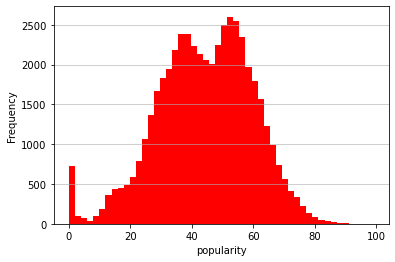

In [33]:
# Plot histogram
n, bins, patches = plt.hist(x=df['popularity'], bins=50, color='r', alpha=1, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('popularity')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

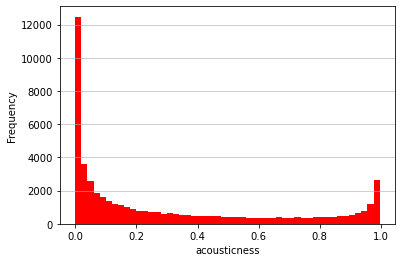

In [34]:
# Plot histogram
n, bins, patches = plt.hist(x=df['acousticness'], bins=50, color='r', alpha=1, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('acousticness')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

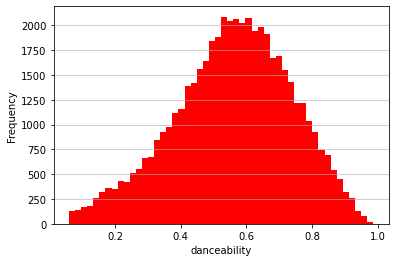

In [35]:
# Plot histogram
n, bins, patches = plt.hist(x=df['danceability'], bins=50, color='r', alpha=1, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('danceability')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

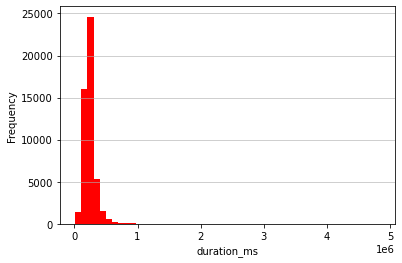

In [36]:
# Plot histogram
n, bins, patches = plt.hist(x=df['duration_ms'], bins=50, color='r', alpha=1, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('duration_ms')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

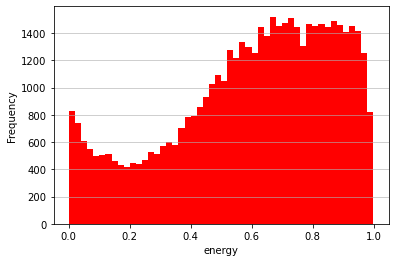

In [37]:
# Plot histogram
n, bins, patches = plt.hist(x=df['energy'], bins=50, color='r', alpha=1, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('energy')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

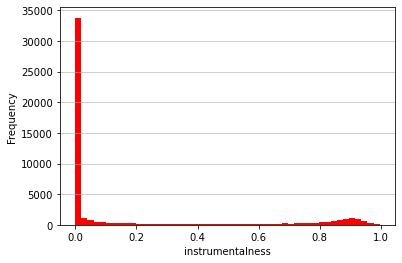

In [38]:
# Plot histogram
n, bins, patches = plt.hist(x=df['instrumentalness'], bins=50, color='r', alpha=1, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('instrumentalness')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

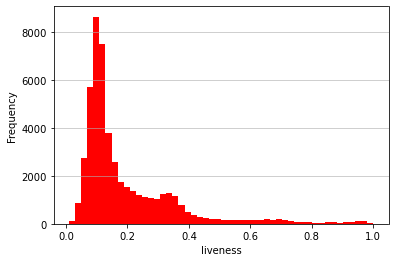

In [39]:
# Plot histogram
n, bins, patches = plt.hist(x=df['liveness'], bins=50, color='r', alpha=1, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('liveness')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

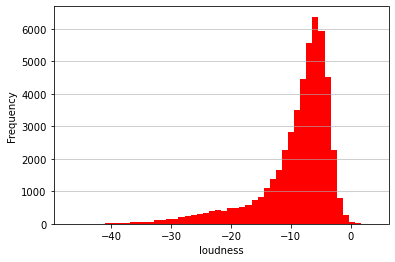

In [40]:
# Plot histogram
n, bins, patches = plt.hist(x=df['loudness'], bins=50, color='r', alpha=1, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('loudness')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

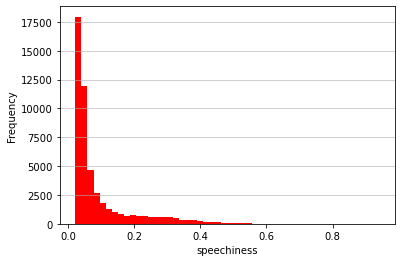

In [41]:
# Plot histogram
n, bins, patches = plt.hist(x=df['speechiness'], bins=50, color='r', alpha=1, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('speechiness')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

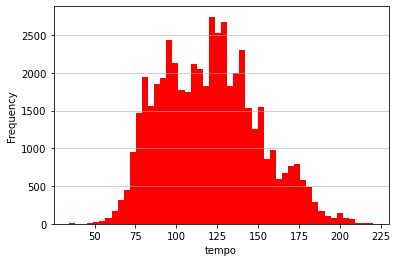

In [42]:
# Plot histogram
n, bins, patches = plt.hist(x=df['tempo'], bins=50, color='r', alpha=1, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('tempo')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

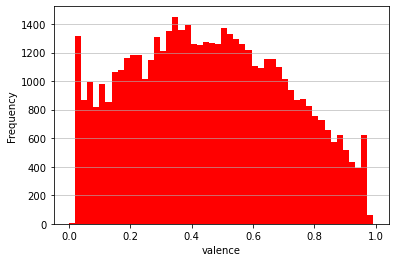

In [43]:
# Plot histogram
n, bins, patches = plt.hist(x=df['valence'], bins=50, color='r', alpha=1, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('valence')
plt.ylabel('Frequency')

#### Hold out categorical variables and target

In [44]:
hold_out_vars = ['A','A#','B','C','C#','D','D#','E','F','F#','G','Major'] 
location = 1

# Hold out categorical variables for PCA
for var in hold_out_vars:   
    df_hold.insert(loc = location, column = var, value = df[var])
    location += 1

# Remove from main frame
df = df.drop(columns = hold_out_vars)

#### Normalize data for BoxCox transform

In [45]:
# Save column names
col_names = list(df)

# Normalize the data
x = df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

# Reset column names
df.columns = col_names

#### Transform data

In [46]:
# Transform data columns using BoxCox to normalize
transform_names = ['popularity','acousticness','danceability','duration_ms','energy',
    'instrumentalness','liveness','loudness','speechiness','tempo','valence']

for i in transform_names:
    #perform Box-Cox transformation on original data
    transformed_data = df[i] + 0.0001
    transformed_data = boxcox(transformed_data) 
    # Replace the data in the data frame
    df[i] = transformed_data[0]

#### Renormalize data

In [47]:
# Save column names
col_names = list(df)

# Normalize the data
x = df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

# Reset column names
df.columns = col_names

Text(0, 0.5, 'Frequency')

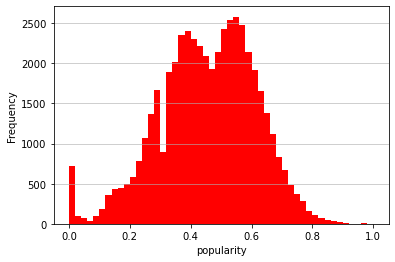

In [48]:
# View transformed distribution
n, bins, patches = plt.hist(x = df['popularity'], bins=50, color='r', alpha=1, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('popularity')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

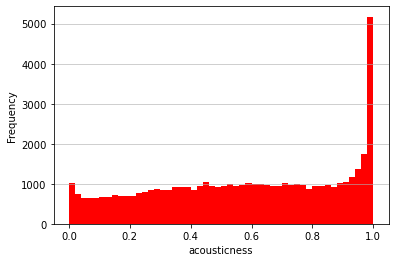

In [49]:
# View transformed distribution
n, bins, patches = plt.hist(x=df['acousticness'], bins=50, color='r', alpha=1, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('acousticness')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

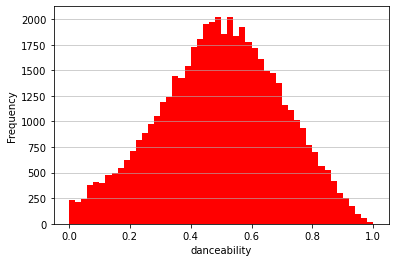

In [50]:
# View transformed distribution
n, bins, patches = plt.hist(x=df['danceability'], bins=50, color='r', alpha=1, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('danceability')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

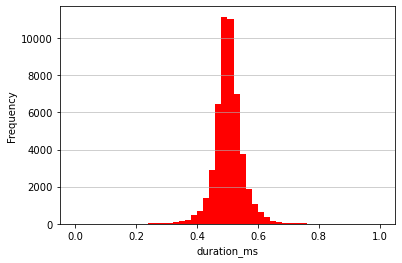

In [51]:
# View transformed distribution
n, bins, patches = plt.hist(x=df['duration_ms'], bins=50, color='r', alpha=1, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('duration_ms')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

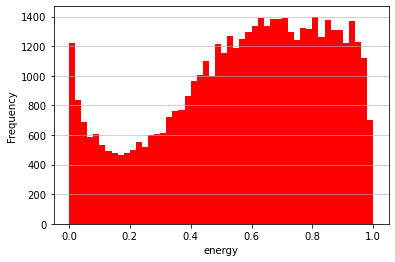

In [52]:
# View transformed distribution
n, bins, patches = plt.hist(x=df['energy'], bins=50, color='r', alpha=1, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('energy')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

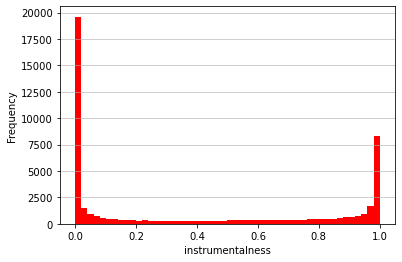

In [53]:
# View transformed distribution
n, bins, patches = plt.hist(x=df['instrumentalness'], bins=50, color='r', alpha=1, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('instrumentalness')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

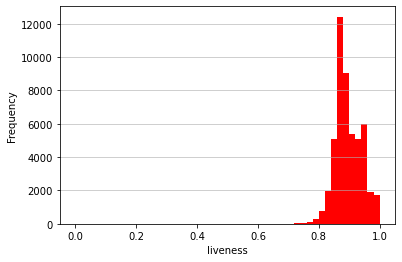

In [54]:
# View transformed distribution
n, bins, patches = plt.hist(x=df['liveness'], bins=50, color='r', alpha=1, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('liveness')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

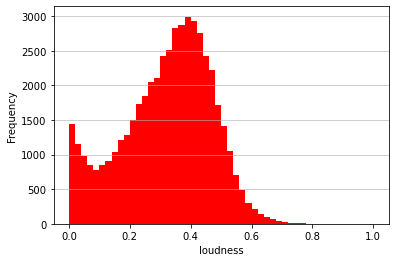

In [55]:
# View transformed distribution
n, bins, patches = plt.hist(x=df['loudness'], bins=50, color='r', alpha=1, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('loudness')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

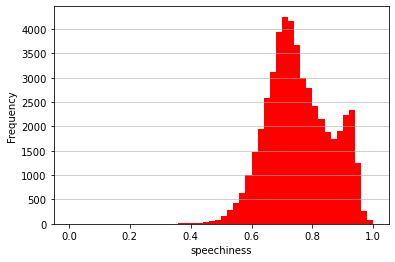

In [56]:
# View transformed distribution
n, bins, patches = plt.hist(x=df['speechiness'], bins=50, color='r', alpha=1, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('speechiness')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

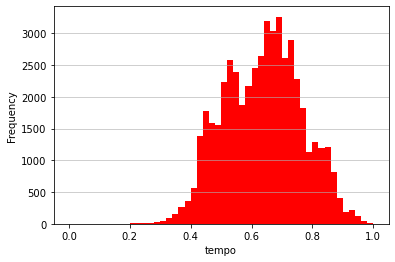

In [57]:
# View transformed distribution
n, bins, patches = plt.hist(x=df['tempo'], bins=50, color='r', alpha=1, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('tempo')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

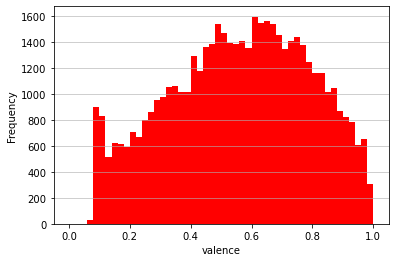

In [58]:
# View transformed distribution
n, bins, patches = plt.hist(x=df['valence'], bins=50, color='r', alpha=1, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('valence')
plt.ylabel('Frequency')

#### Run PCA

In [59]:
# Convert to array
X = df.to_numpy()

# Find the mean 𝜇 ( 𝑑 -dimensional vector) of all samples
mu = np.mean(X, axis=0)

# Compute the covariance matrix 
C = (X - mu).T @ (X - mu)

# Reformat covariance matrix
C_1 = []
for i in C:
    row = [float("{:.2f}".format(j)) for j in i]
    C_1.append(row)
    
# Calculate sum of diagonal
i = 0
diagonal_sum = 0
for j in C_1:
    diagonal_sum += j[i]
    i += 1

# Print diagonal sum
print(diagonal_sum)

25595.359999999997


In [60]:
# Compute the 𝑘 eigenvectors of 𝐶
eigvals, eigvecs = np.linalg.eig(C)
eigvals_1 = [float("{:.2f}".format(i)) for i in eigvals if i > 1]
print('Eigenvalues: ', eigvals_1)
print('Count: ', len(eigvals_1))

Eigenvalues:  [11654.69, 6252.34, 2764.16, 1533.81, 998.91, 819.87, 727.4, 462.71, 186.2, 85.32, 109.94]
Count:  11


In [61]:
# Calculate sum
total_var = sum(eigvals_1)
print(total_var)

25595.35


In [62]:
# Run PCA on the data
pca = PCA(n_components=11, whiten=True)
pca.fit(X);
X_pca = pca.transform(X)

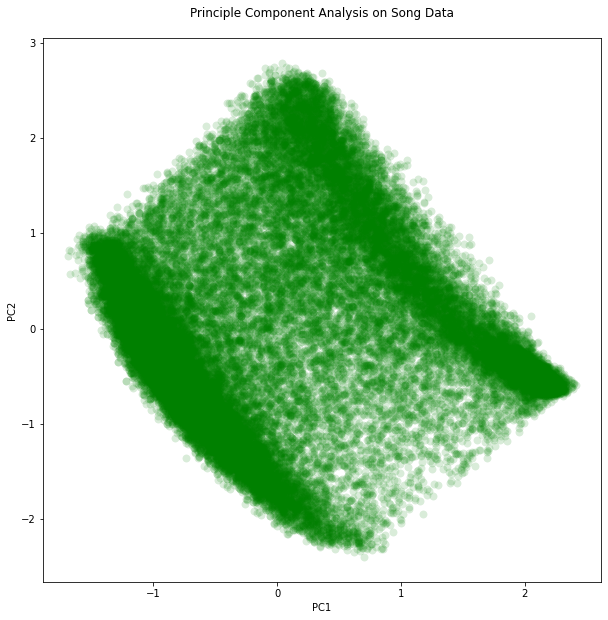

In [63]:
# Plot the first two principle components
plt.figure(figsize=(10, 10))
plt.scatter(X_pca[:,0], X_pca[:,1], marker=".", s=250, lw=0, alpha=0.15, c='green')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Principle Component Analysis on Song Data\n')
plt.show()

#### Determine important factors

In [64]:
# Isolate top 2 PCs
pcs = pd.DataFrame()
pcs.insert(loc=0, column ='pc1', value = X_pca[:,0])
pcs.insert(loc=1, column ='pc2', value = X_pca[:,1])

In [65]:
# Observe the correlations
pd.set_option('display.max_columns', 25)
df_corr = pd.concat([df, pcs], axis=1).corr()
df_corr

popularity  acousticness  danceability  duration_ms  \
popularity          1.000000     -0.175998      0.355904    -0.054039   
acousticness       -0.175998      1.000000     -0.156016    -0.003994   
danceability        0.355904     -0.156016      1.000000    -0.150436   
duration_ms        -0.054039     -0.003994     -0.150436     1.000000   
energy              0.206327     -0.724408      0.235244    -0.014158   
instrumentalness   -0.377582      0.152715     -0.296755     0.155250   
liveness           -0.015030     -0.106289     -0.052603    -0.021770   
loudness            0.270451     -0.638421      0.286422    -0.059619   
speechiness         0.185999     -0.169361      0.261857    -0.108042   
tempo               0.041249     -0.237484      0.017218    -0.017506   
valence             0.140854     -0.175161      0.443648    -0.150141   
pc1                -0.438757      0.578240     -0.442061     0.139105   
pc2                -0.111649     -0.716285     -0.030741     0.103774   

                    energy  instrumentalness  liveness  loudness  speechiness  \
popularity        0.206327         -0.377582 -0.015030  0.270451     0.185999   
acousticness     -0.724408          0.152715 -0.106289 -0.638421    -0.169361   
danceability      0.235244         -0.296755 -0.052603  0.286422     0.261857   
duration_ms      -0.014158          0.155250 -0.021770 -0.059619    -0.108042   
energy            1.000000         -0.290818  0.186720  0.856927     0.239115   
instrumentalness -0.290818          1.000000 -0.082189 -0.434876    -0.188152   
liveness          0.186720         -0.082189  1.000000  0.148354     0.113552   
loudness          0.856927         -0.434876  0.148354  1.000000     0.204080   
speechiness       0.239115         -0.188152  0.113552  0.204080     1.000000   
tempo             0.277404         -0.105164  0.051918  0.252453     0.109189   
valence           0.410482         -0.262210  0.037796  0.319747     0.069479   
pc1              -0.716507          0.843957 -0.132260 -0.763096    -0.278100   
pc2               0.592169          0.518016  0.075905  0.394685     0.051511   

                     tempo   valence           pc1           pc2  
popularity        0.041249  0.140854 -4.387566e-01 -1.116492e-01  
acousticness     -0.237484 -0.175161  5.782401e-01 -7.162848e-01  
danceability      0.017218  0.443648 -4.420607e-01 -3.074123e-02  
duration_ms      -0.017506 -0.150141  1.391049e-01  1.037739e-01  
energy            0.277404  0.410482 -7.165073e-01  5.921686e-01  
instrumentalness -0.105164 -0.262210  8.439573e-01  5.180161e-01  
liveness          0.051918  0.037796 -1.322602e-01  7.590495e-02  
loudness          0.252453  0.319747 -7.630964e-01  3.946845e-01  
speechiness       0.109189  0.069479 -2.780996e-01  5.151059e-02  
tempo             1.000000  0.125931 -2.363812e-01  1.906100e-01  
valence           0.125931  1.000000 -4.746102e-01  1.048027e-01  
pc1              -0.236381 -0.474610  1.000000e+00 -4.208584e-16  
pc2               0.190610  0.104803 -4.208584e-16  1.000000e+00

0: instrumentalness (> 0.8), loudness, energy (> 0.7)  
1: acousticness (> 0.7)

#### kMeans on PCA components

In [66]:
# Set range of clusters to test
range_n_clusters = range(2, 11)

For n_clusters = 2 The average silhouette_score is : 0.46173254343283626
For n_clusters = 3 The average silhouette_score is : 0.5089876716930315
For n_clusters = 4 The average silhouette_score is : 0.4854504279674382
For n_clusters = 5 The average silhouette_score is : 0.47317964146856767
For n_clusters = 6 The average silhouette_score is : 0.45385251704587704
For n_clusters = 7 The average silhouette_score is : 0.43074379619274783
For n_clusters = 8 The average silhouette_score is : 0.41249332943453204
For n_clusters = 9 The average silhouette_score is : 0.4224140328870411
For n_clusters = 10 The average silhouette_score is : 0.42628157438052783


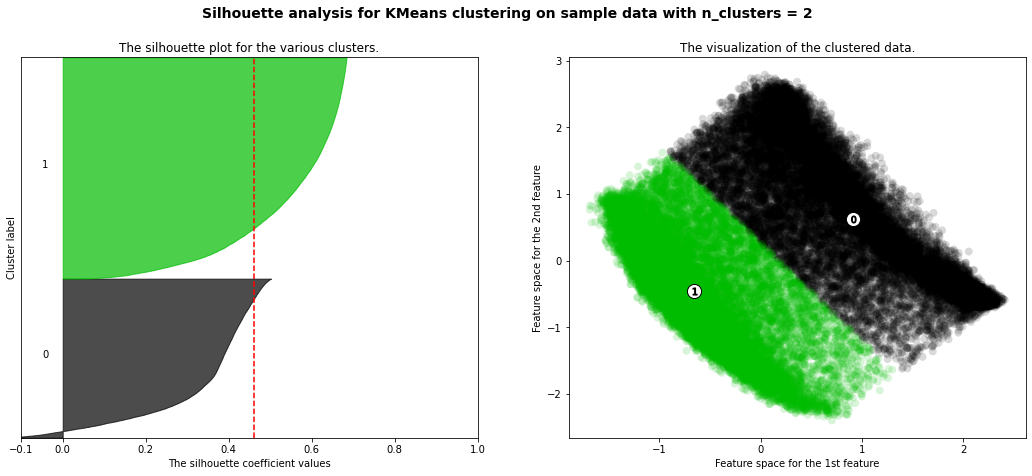

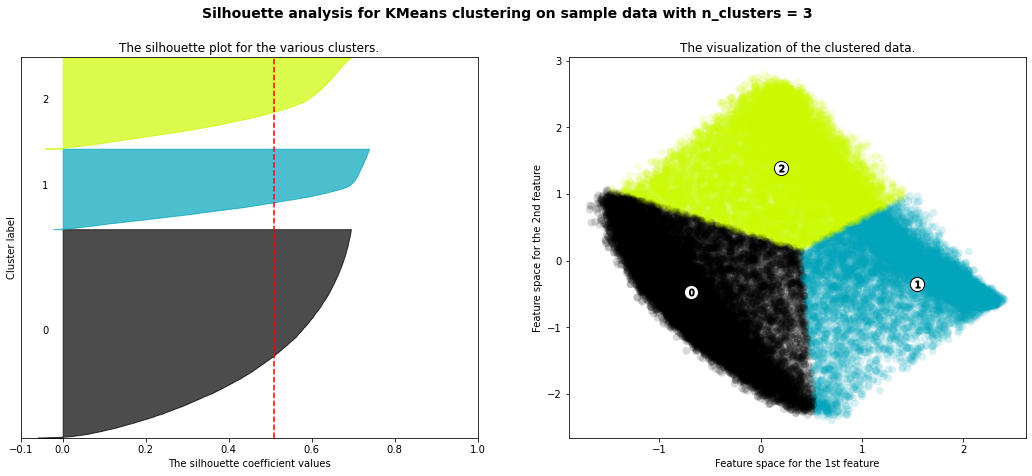

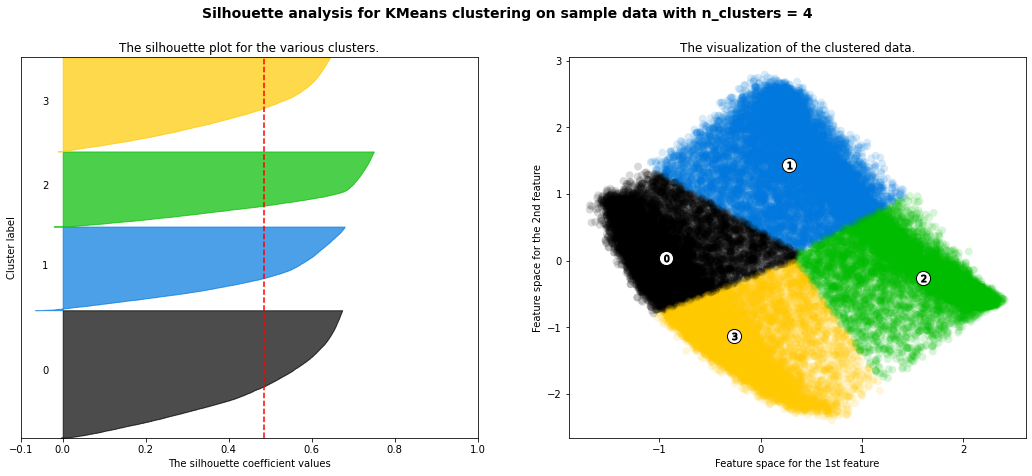

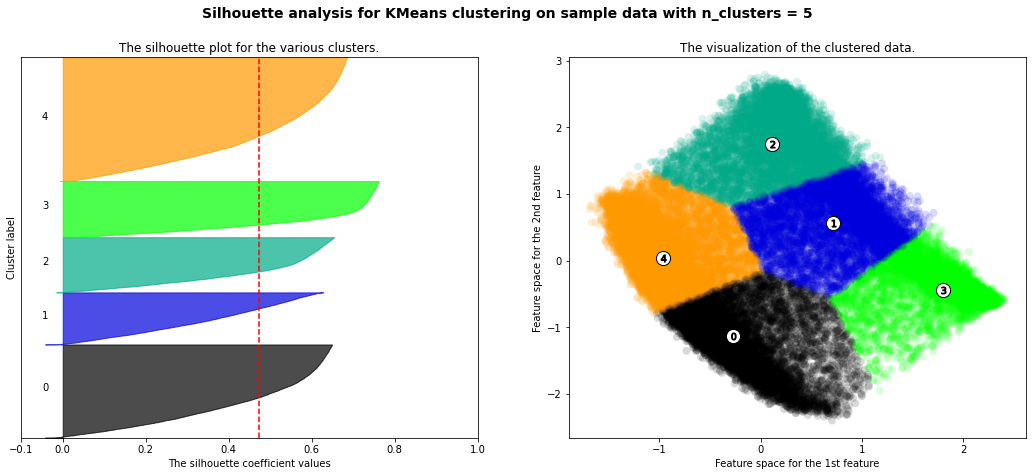

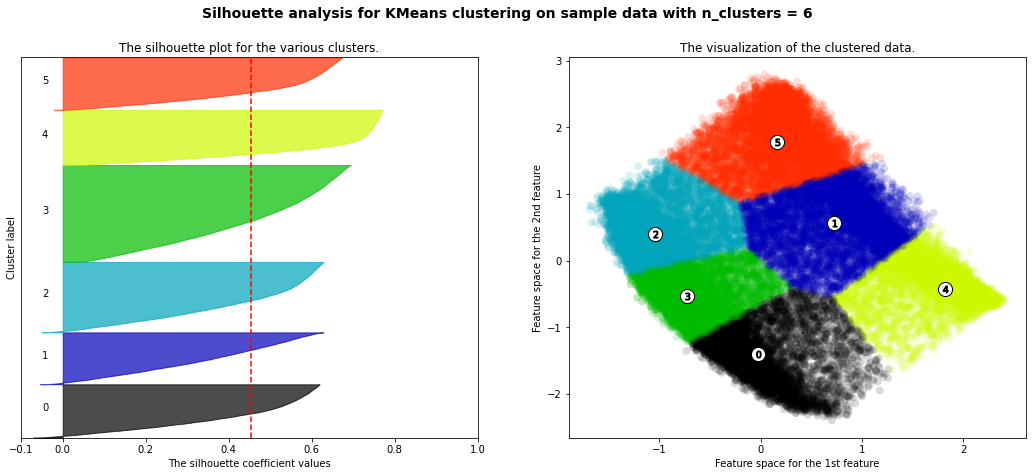

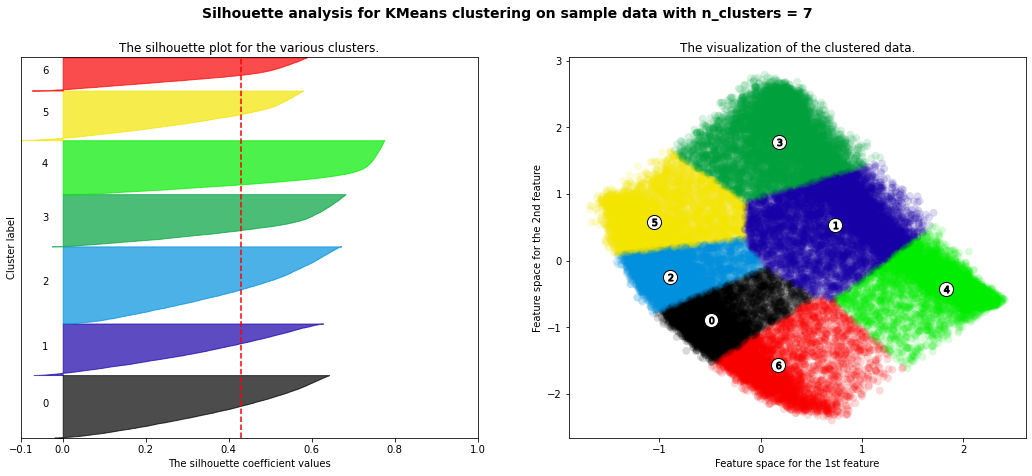

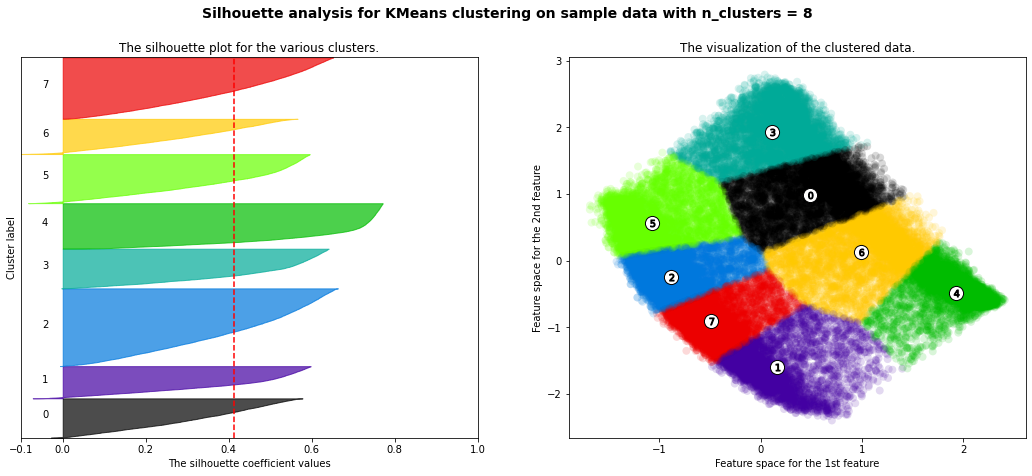

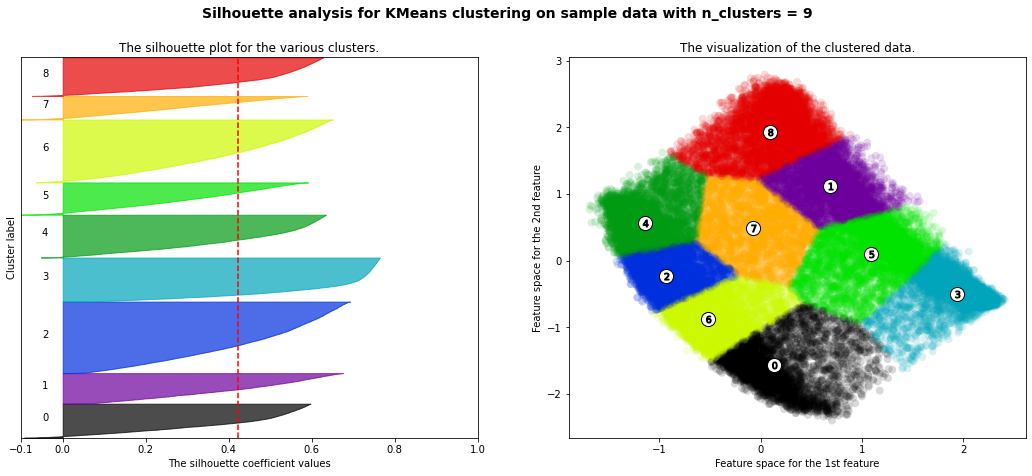

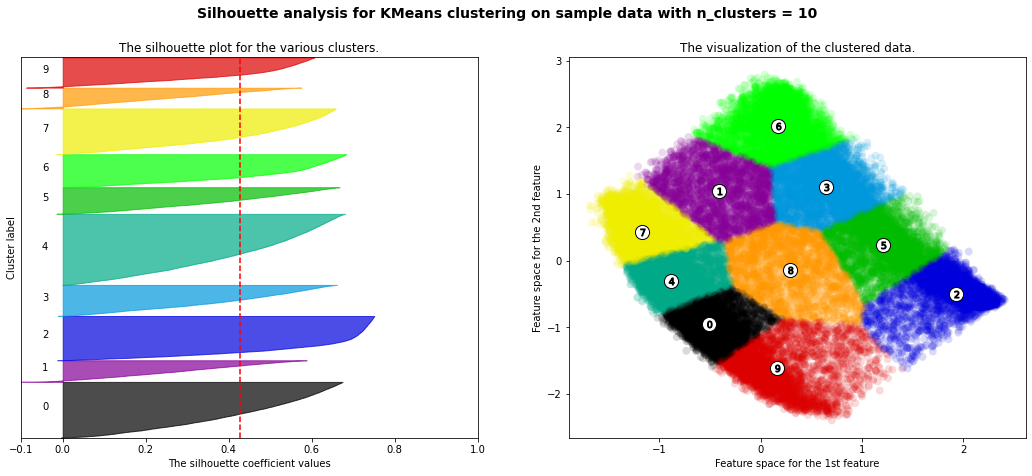

In [67]:
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    # plots of individual clusters, to demarcate them clearly
    ax1.set_ylim([0, len(pcs) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(pcs)
    
    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(pcs, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(pcs, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color,
            edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(np.array(pcs['pc1']), np.array(pcs['pc2']), marker=".", s=250, lw=0, alpha=0.15, c=colors, edgecolor="k")
        
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

#### Divide into train/test sets

In [67]:
# Rejoin with categorical and target variables
X_pca = pd.DataFrame(X_pca)
df = pd.concat([df_hold, X_pca], axis=1)
df.head()

music_genre    A   A#    B    C   C#    D   D#    E    F   F#    G  Major  \
0  Electronic  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0   
1  Electronic  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0    0.0   
2  Electronic  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    1.0   
3  Electronic  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0    1.0   
4  Electronic  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0    1.0   

          0         1         2         3         4         5         6  \
0  0.150783  2.254868 -1.189527 -0.366321  0.334892  0.891909  0.940242   
1  0.414016  1.978694 -0.623679 -0.168306  0.045761  0.618411  0.529095   
2  0.023564  1.499514  0.464769  0.332424  0.670893  1.253361 -0.107843   
3 -0.123613  0.790092  0.170194  1.273121 -0.323343  2.037683 -0.558067   
4  0.657280  1.706335  0.135214  0.958080  0.986699  0.766034 -0.982544   

          7         8         9        10  
0 -0.570340  0.078988 -0.249995  0.598697  
1  1.280527 -1.286049 -0.694346  0.321367  
2  1.186584  0.772785 -0.447748 -1.880151  
3 -0.602013  1.317638 -0.609312 -0.055156  
4  0.798605  1.382560 -0.115341 -0.456581

In [68]:
# Get lists of column names
column_names = list(df)

# Split dataframe into features and target
x = df.drop(columns = 'music_genre')
y = pd.DataFrame(df['music_genre'])

In [69]:
# Create master test and train sets to add to
x_train = pd.DataFrame(columns = column_names[1:])
x_test = pd.DataFrame(columns = column_names[1:])
y_train = pd.DataFrame(columns = [column_names[0]])
y_test = pd.DataFrame(columns = [column_names[0]])

In [70]:
# Get target categories as a list
genres = df['music_genre'].unique()

In [71]:
for genre in genres:
    # Split data into each category
    y_new = y[y['music_genre'] == genre]
    y_ind = y_new.index.values.tolist()
    x_new = x.iloc[min(y_ind):max(y_ind)+1]
    # Divide into 1/10 for test, and 9/10 for train
    x_tr, x_te, y_tr, y_te = train_test_split(x_new, y_new, test_size=0.1, random_state = seed)
    # Add to master sets
    x_train = x_train.append(x_tr)
    x_test = x_test.append(x_te)
    y_train = y_train.append(y_tr)
    y_test = y_test.append(y_te)

#### Hyperparameter tuning

In [78]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(10, 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

In [79]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 50 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=seed, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [80]:
rf_random.best_params_

{'n_estimators': 115,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': True}

#### Fit Random Forest model

In [82]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)
y_train = np.array(y_train).flatten()
y_test = np.array(y_test).flatten()

In [83]:
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators=115, min_samples_split=10, min_samples_leaf=4, max_features='sqrt', max_depth=90, bootstrap=True, criterion = 'entropy', random_state = seed)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=90, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=115)

#### Make predictions using model

In [84]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [85]:
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Genre'], colnames=['Predicted Genre']))

Predicted Genre  Alternative  Anime  Blues  Classical  Country  Electronic  \
Actual Genre                                                                 
Alternative              155      8     17          1       71          31   
Anime                     12    361     30         39       17          22   
Blues                     17     61    240         10       50          19   
Classical                 20     21      8        400        4           9   
Country                   18     16     30          0      282           7   
Electronic                18     38     32          1       14         307   
Hip-Hop                   17      0      2          0        7          10   
Jazz                      20      9     57         29       30          65   
Rap                       19      0      0          0        4           7   
Rock                      71      0      4          4       53           4   

Predicted Genre  Hip-Hop  Jazz  Rap  Rock  
Actual Genre       

#### Assess accuracy

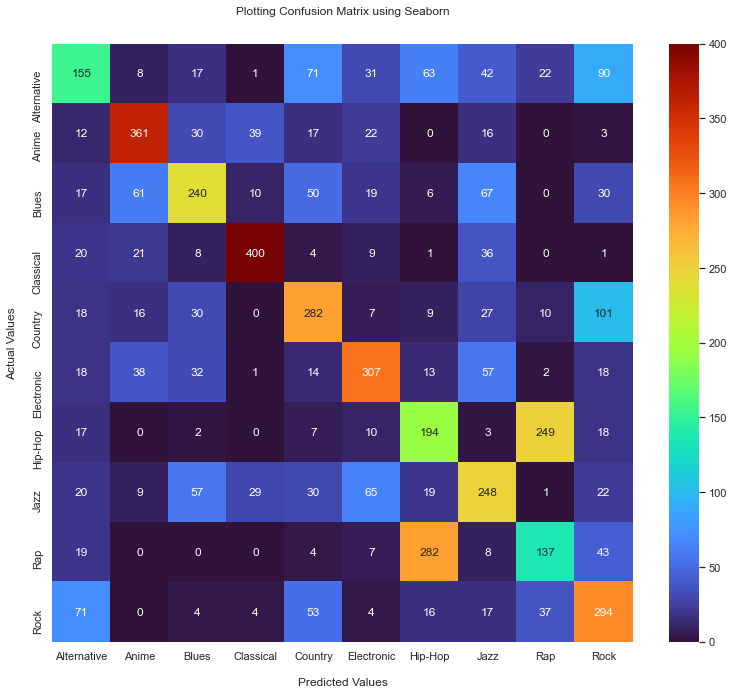

In [86]:
sns.set(rc={'figure.figsize':(13,11)})

conf_matrix = (confusion_matrix(y_test, y_pred))

# Using Seaborn heatmap to create the plot
fx = sns.heatmap(conf_matrix, annot=True, cmap='turbo', fmt='g')

# labels the title and x, y axis of plot
fx.set_title('Plotting Confusion Matrix using Seaborn\n\n');
fx.set_xlabel('\nPredicted Values')
fx.set_ylabel('Actual Values\n');

alpha_genres = ['Alternative', 'Anime', 'Blues', 'Classical', 'Country', 'Electronic', 'Hip-Hop', 'Jazz', 'Rap', 'Rock']

# labels the boxes
fx.xaxis.set_ticklabels(alpha_genres)
fx.yaxis.set_ticklabels(alpha_genres)

plt.show()

In [87]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))


Accuracy: 0.52



In [88]:
# Accuracy by genre
for genre in genres:
    # Split data into each category
    y_test_new = y_test[y_test == genre]
    y_pred_new = y_pred[y_test == genre]
    # Calculate accuracy for each value
    print(genre, 'Accuracy: {:.2f}\n'.format(accuracy_score(y_test_new, y_pred_new)))

Electronic Accuracy: 0.61

Anime Accuracy: 0.72

Jazz Accuracy: 0.50

Alternative Accuracy: 0.31

Country Accuracy: 0.56

Rap Accuracy: 0.27

Blues Accuracy: 0.48

Rock Accuracy: 0.59

Classical Accuracy: 0.80

Hip-Hop Accuracy: 0.39



#### Assess AUC/ROC

In [89]:
y_hat = classifier.predict_proba(X_test)

In [90]:
# Change y_test to encoded values
y_test_encode = np.zeros(len(y_test))

In [91]:
for i in range(len(y_test_encode)):
    if y_test[i] == 'Alternative':
        y_test_encode[i] = 0
    elif y_test[i] == 'Anime':
        y_test_encode[i] = 1
    elif y_test[i] == 'Blues':
        y_test_encode[i] = 2
    elif y_test[i] == 'Classical':
        y_test_encode[i] = 3
    elif y_test[i] == 'Country':
        y_test_encode[i] = 4
    elif y_test[i] == 'Electronic':
        y_test_encode[i] = 5
    elif y_test[i] == 'Hip-Hop':
        y_test_encode[i] = 6
    elif y_test[i] == 'Jazz':
        y_test_encode[i] = 7
    elif y_test[i] == 'Rap':
        y_test_encode[i] = 8
    elif y_test[i] == 'Rock':
        y_test_encode[i] = 9

In [92]:
y_test_encode = y_test_encode.astype(int)

In [93]:
def plot_roc_curve(y_test, y_pred):
    
    # Encode y_test
    encoder = {0:'Alternative',1:'Anime',2:'Blues',3:'Classical',4:'Country',
               5:'Electronic',6:'Hip-Hop',7:'Jazz',8:'Rap',9:'Rock'} 

    n_classes = len(np.unique(y_test))
    y_test = label_binarize(y_test, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    thresholds = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], y_pred[:, i], drop_intermediate=False)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    #plt.figure(figsize=(10,5))
    plt.figure(dpi=600)
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink", linestyle=":", linewidth=4,)

    plt.plot(fpr["macro"], tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy", linestyle=":", linewidth=4,)

    colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "blue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, label="ROC curve: {0} (area = {1:0.2f})".format(encoder[i], roc_auc[i]),)

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("\nFalse Positive Rate")
    plt.ylabel("True Positive Rate\n")
    plt.title("Receiver Operating Characteristic (ROC) curve\n")
    plt.legend()
    
    for i in range(n_classes):
        print("{0} AUC = {1:0.2f}".format(encoder[i], roc_auc[i]))

Alternative AUC = 0.84
Anime AUC = 0.96
Blues AUC = 0.90
Classical AUC = 0.97
Country AUC = 0.92
Electronic AUC = 0.93
Hip-Hop AUC = 0.91
Jazz AUC = 0.89
Rap AUC = 0.90
Rock AUC = 0.92


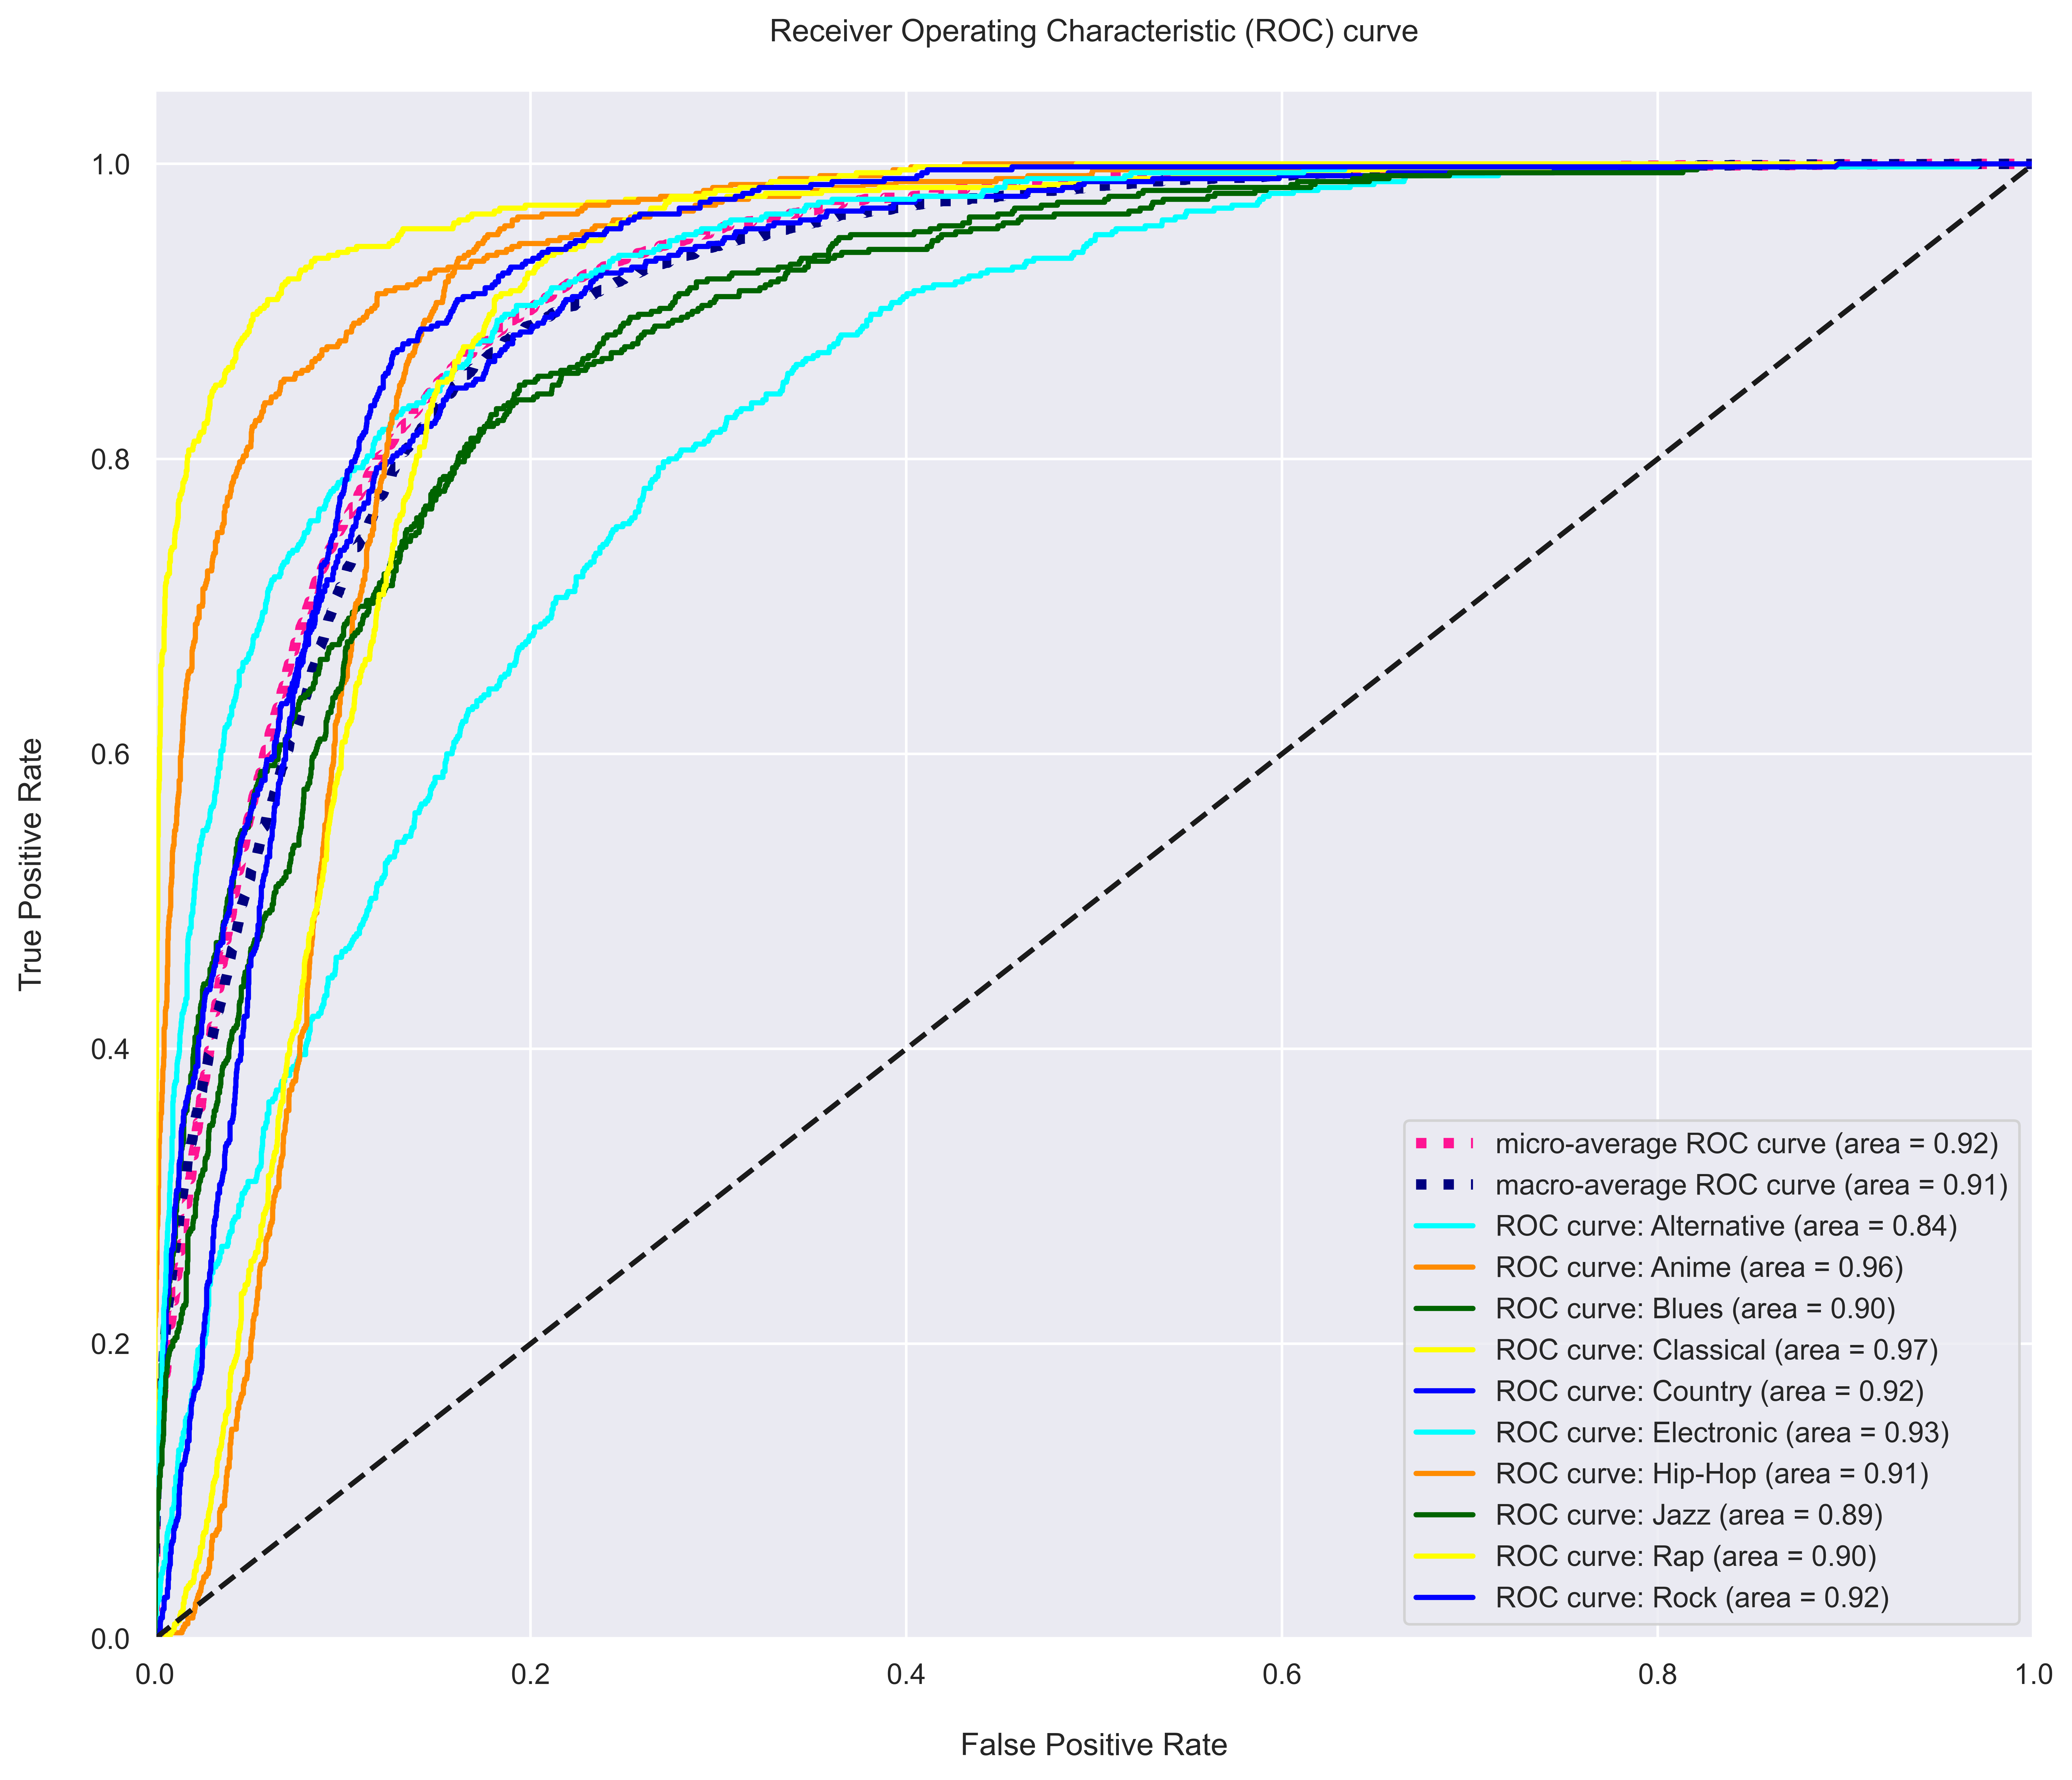

In [94]:
# Plot ROC curves for all
plot_roc_curve(y_test_encode, y_hat)